In [1]:
import numpy as np
from src.sources.fft import FFTSource
import matplotlib.pyplot as plt

from collections import deque
import cv2
import time
import tkinter as tk
from PIL import Image, ImageTk

import math

from src.visualisers.camera_gui import display
from src.sources.video_helper import get_differences, get_differences_2D

def convert_to_chart(array, max_value=256, flip=True):
    """Convert 1D numpy array to a chart image.
    
    Args:
        array - 1D numpy with data to convert to plot.
        max_value - maximum value in the array.
        flip - boolean flag to correct the output when positive."""
    # Create a "blank", i.e. white with 255, image array
    blank_image = np.ones(shape=(max_value, array.shape[0]))*255
    # Create a 2D mask from the data
    mask = array[:, None] >= np.arange(max_value)
    # Then flip the mask to align with the image and set to 0 (black)
    blank_image[mask.T] = 0
    # We then just need to flip the output again to get back to the original 
    if flip:
        chart_image = np.flipud(blank_image)
    else:
        chart_image = blank_image
    return chart_image

class MeanBuffer:
    """This is similar to our sensor and buffer objects."""
    
    def __init__(self, vec_len, time_period):
        """Initialise.
        
        Args:
            time_period - integer period over which to determine the mean.
        """
        self.time_period = time_period
        self.count = 0
        self.running_sum = np.zeros(shape=(vec_len, 1))
        self.buffered_mean = np.zeros(shape=(vec_len, 1))
        
    def iterate(self, input_data):
        """Iterate using input_data."""
        self.count += 1
        self.running_sum += input_data
        # If end of period
        if (self.count) % self.time_period == 0:
            # Replace old buffered mean with new mean
            self.buffered_mean = ((self.running_sum / self.time_period)*255).astype(np.int16)
            # Reset running sum
            self.running_sum.fill(0)
            # Reset count
            self.count = 0
    
    @property
    def mean(self):
        """Return mean."""
        # If no buffered mean
        if (self.buffered_mean == 0).all():
            mean = ((self.running_sum / self.count)*255).astype(np.int16)
        else:
            mean = self.buffered_mean.copy().astype(np.int16)
        return mean
    
    def mean_ternary(self):
        """Return mean as a ternary value in set -1, 0, 1."""
        # Sample using fraction as probability - from ternary_pbt
        rand_ints = np.random.randint(
            low=0,
            high=255,
            size=self.mean.shape
        )
        signs = np.sign(self.mean)
        pbt_output = np.where(np.abs(self.mean) > rand_ints, 1, 0)
        # Add to next stage (with signs returned)
        resigned = pbt_output*signs
        return resigned.astype(np.int8)
    
    def __repr__(self):
        """Print output."""
        return mean

In [2]:
fftsource = FFTSource(res_factor=2)
fftsource.start()

In [3]:
class MeanAudioGUI:
    
    def __init__(self, sensor, num_of_buffers=8, group_size=2):
        # Setup gui
        self.window = tk.Tk()
        
        # Setup FPS and Quit Button on First Row
        button_frame = tk.Frame(self.window)
        button_frame.pack(expand=True, fill=tk.BOTH)
        # quit button
        self.quit_button = tk.Button(button_frame, text='Quit', command=lambda: self.quit_())
        self.quit_button.pack(side=tk.RIGHT, padx=5, pady=5)
        
        # Create a list of panels for the GUI
        self.panels = list()
        self.canvas_content = list()
        for i in range(num_of_buffers):
            # Create a canvas for each panel
            canvas = tk.Canvas(self.window, width=512, height=64)
            canvas.pack(expand=True, fill=tk.BOTH)
            self.panels.append(canvas)
            self.canvas_content.append(None)
                         
        # Setup sensor
        self.add_sensor(sensor)
        _, data = sensor.read()
        
        # Create mean buffers
        self.num_of_buffers = num_of_buffers
        self.mean_buffers = [MeanBuffer(data.shape[0], group_size**i) for i in range(num_of_buffers)]
        
    def add_sensor(self, sensor):
        """Add a sensor to the GUI for display."""
        self.sensor = sensor
        # Start sensor if not already started
        if not self.sensor.started:
            self.sensor.start()
    
    def update(self):
        # Get audio frame
        _, data = self.sensor.read()
        # PBT
        rand_ints = np.random.randint(255, size=(data.shape))
        binary_values = np.where(data > rand_ints, 1, 0)
        input_data = binary_values.reshape(-1, 1)
        # Iterate through buffers in reverse
        for mb in reversed(self.mean_buffers):
            mb.iterate(input_data)
            input_data = input_data - mb.mean_ternary()
        
        # Display the mean values of each buffer
        for i in range(self.num_of_buffers):
            # Convert to image of histogram
            mean = self.mean_buffers[i].mean.ravel()
            positive_chart_image = convert_to_chart(mean)
            negative_chart_image = convert_to_chart(-1*mean, flip=False)
            chart_image = np.concatenate([positive_chart_image, negative_chart_image], axis=0)
            # display(chart_image, self.original_fft)
            pil_image = Image.fromarray(chart_image)
            pil_image = pil_image.resize((512, 64))
            photo_image = ImageTk.PhotoImage(image=pil_image)
            if self.canvas_content[i] is None:
                # print("Creating chart")
                self.canvas_content[i] = self.panels[i].create_image(0, 0, image=photo_image, anchor=tk.NW)
            else:
                # print("Configuring chart")
                self.panels[i].itemconfig(self.canvas_content[i], image=photo_image)
                self.panels[i].image = photo_image
                
        self.window.after(30, self.update)
    
    def run(self):
        self.update()
        self.window.mainloop()
        
    def quit_(self):
        self.sensor.stop()
        self.window.destroy()

In [4]:
m = MeanAudioGUI(fftsource)

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


In [5]:
m.run()

/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


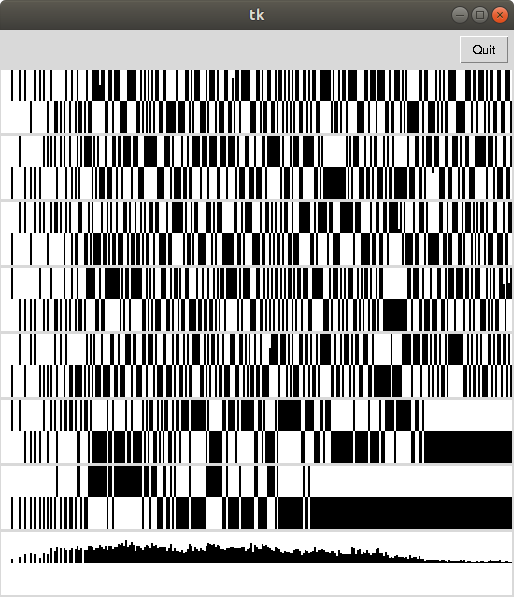

We get fast moving patterns at the top and slower moving patterns as we move down. The base mean is similar to previous non-binary versions.

There is more movement at the lower stages that there was with the integer version.

Funny how this still has useful information despite the mean being an integer value that is subtracted from a binary value!

How is the mean still binary?! Is it because overflow is forcing 255 and -255? Yes as the scale is the same as the bottom chart.

We would get this if we just took the signs of the original differences.

If we subtract a ternary mean we get this:
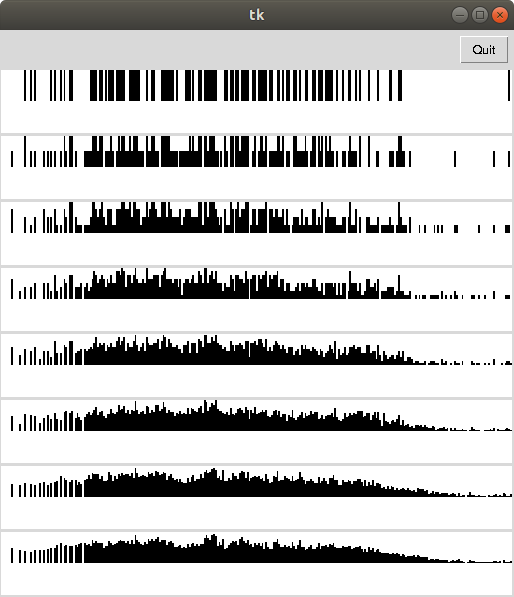

In [6]:
m.mean_buffers[0].mean_ternary()

array([[ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 1],
       [ 0],
       [ 0],
       [-1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [-1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [-1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [-1],
       [-1],
       [ 0],
       [ 1],
       [ 0],
       [ 0],
       [-1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 1],
       [ 1],
       [ 0],
       [ 0],
       [ 0],
       [ 1],
       [-1],
       [ 0],
       [ 1],
       [-1],
       [-1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [-1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [-1],
       [ 0],
       [ 0],
       [-1],
       [ 1],
       [ 0],
       [ 1],
       [ 0],
       [-1],
       [ 0],
       [ 0],

mean_ternary is always 0.

In [7]:
m.mean_buffers[4].mean

array([[   0],
       [   0],
       [   0],
       [   0],
       [   0],
       [   0],
       [-127],
       [   0],
       [   0],
       [   0],
       [   0],
       [   0],
       [   0],
       [ -15],
       [   0],
       [   0],
       [  15],
       [   0],
       [  63],
       [   0],
       [   0],
       [   0],
       [   0],
       [  31],
       [   0],
       [ -15],
       [   0],
       [   0],
       [   0],
       [  63],
       [-143],
       [   0],
       [ -31],
       [   0],
       [  47],
       [ -31],
       [   0],
       [ -31],
       [  15],
       [   0],
       [  31],
       [ -79],
       [ -63],
       [  79],
       [   0],
       [ -63],
       [-111],
       [ -47],
       [   0],
       [ -15],
       [  79],
       [ -15],
       [ -47],
       [ -63],
       [  63],
       [ -95],
       [  95],
       [  15],
       [   0],
       [ -47],
       [  63],
       [-127],
       [-111],
       [   0],
       [ -31],
       [ 111],
       [  

In [8]:
mean = m.mean_buffers[4].mean / 255
print(mean.T)
# Copy fraction to vec_len
prob_vector = mean
# print(prob_vector.T)
# Sample using fraction as probability - from ternary_pbt
rand_ints = np.random.uniform(size=prob_vector.shape)
signs = np.sign(prob_vector)
pbt_output = np.where(np.abs(prob_vector) > rand_ints, 1, 0)
# Add to next stage (with signs returned)
resigned = pbt_output*signs
print(resigned.astype(np.int8).T)

[[ 0.          0.          0.          0.          0.          0.
  -0.49803922  0.          0.          0.          0.          0.
   0.         -0.05882353  0.          0.          0.05882353  0.
   0.24705882  0.          0.          0.          0.          0.12156863
   0.         -0.05882353  0.          0.          0.          0.24705882
  -0.56078431  0.         -0.12156863  0.          0.18431373 -0.12156863
   0.         -0.12156863  0.05882353  0.          0.12156863 -0.30980392
  -0.24705882  0.30980392  0.         -0.24705882 -0.43529412 -0.18431373
   0.         -0.05882353  0.30980392 -0.05882353 -0.18431373 -0.24705882
   0.24705882 -0.37254902  0.37254902  0.05882353  0.         -0.18431373
   0.24705882 -0.49803922 -0.43529412  0.         -0.12156863  0.43529412
   0.24705882 -0.30980392 -0.05882353  0.          0.18431373 -0.12156863
   0.05882353  0.12156863  0.         -0.12156863 -0.05882353  0.
  -0.18431373 -0.12156863  0.30980392 -0.18431373  0.18431373  0.
   0

In [9]:
# Copy fraction to vec_len
prob_vector = m.mean_buffers[4].mean
# print(prob_vector.T)
# Sample using fraction as probability - from ternary_pbt
rand_ints = np.random.randint(255, size=prob_vector.shape)
signs = np.sign(prob_vector)
pbt_output = np.where(np.abs(prob_vector) > rand_ints, 1, 0)
# Add to next stage (with signs returned)
resigned = pbt_output*signs
print(resigned.astype(np.int8).T)

[[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0 -1  0  1  0  0 -1  0
   0  0  0  0  0  0  1  0  0  0  0 -1  0 -1  0  0  0  0  0 -1  0  0  0  0
   0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0 -1  0  0  0  1  0  0  0  0
  -1  0 -1  0  0  1  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0
   0  0  0 -1 -1  0  0  0  1  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0
   0  0  0  1  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0
   0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0  0  0 -1  0 -1  0  1  0  0  0  0  0  0  0  0  1  0  0  0
   0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
   0  0  0  0  0  0  0  0  0  0]]


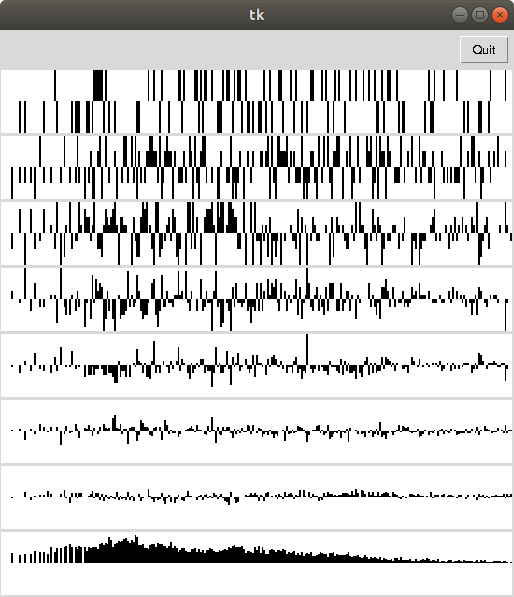

This is more what I was expecting - you can see how the number of possible values gets higher as we move down (the first stage is ternary, then 4 levels, then 8 etc).

Also note that the same pattern of smaller values as we move down appears to apply - so despite bigger ranges not all of this range is used.

It would be interesting to see these patterns over time - i.e. as a spectrogram.

Is it too much randomness though? But to get rid of this you just integrate over time?

---

This shows the residual ranges - at each stage values are clustered around 0. But if we clip is this going to ruin things? Do we instead need to model over time to get accurate results?

In [10]:
m2 = MeanAudioGUI(fftsource, group_size=4)
m2.run()

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})
/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


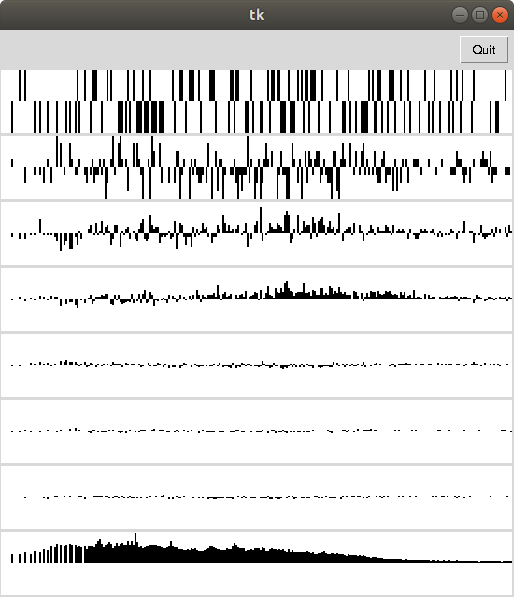

## Top Down VPU-Style Implementation

Now let's try to filter the signal through a series of VPU-like objects to apply a more top down processing pattern....

This is like performing convolution with the vector ```[1, 1, 1, 1]```.

In [11]:
class MeanVPU:
    
    def __init__(self, vec_len, stage):
        """Initialise.

        Args:
            vec_len: 8-bit unsigned integer setting
                the 1D size of an input.
            stage: 8-bit unsigned integer indicating the stage of the VPU,
                starts at 0.
        """
        assert isinstance(vec_len, int)
        self.vec_len = vec_len
        self.stage = stage
        # Set denominator based on the stage
        self.denominator = vec_len**(stage+1)
        self.eigenvector = np.ones(shape=(vec_len, 1), dtype=np.int16)
        
    def forward(self, input_data):
        """Forward transform."""
        assert input_data.shape[0] == self.vec_len
        projection = np.dot(self.eigenvector.T, input_data)
        return projection
    
    def backward(self, input_data):
        """Backward transform.
        
        Args:
            input_data - 8-bit unsigned integer representing
                the numerator of a mean fraction."""
        # Generate a set of random integers with max value denominator of size vec_len
        rand_ints = np.random.randint(
            low=0,
            high=self.denominator,
            size=(self.vec_len, 1)
        )
        # This is equal to comparing input_data/denominator with a set of rand values between 0 and 1
        pbt_output = np.where(input_data > rand_ints, 1, 0).astype(np.int16)
        return pbt_output 
        

In [12]:
mean_vpu = MeanVPU(4, 0)

In [13]:
half = np.asarray([0, 1, 1, 0]).reshape(-1, 1); print(half)

[[0]
 [1]
 [1]
 [0]]


In [14]:
forward = mean_vpu.forward(half); print(forward)

[[2]]


In [15]:
backward = mean_vpu.backward(forward); print(backward)

[[1]
 [1]
 [0]
 [0]]


In [16]:
mean_vpu.denominator

4

So we would select a random integer from the set {0, 1, 2, 3}. In the normal one we'd create an array of size 4 with values all equal to 2. If the input is 4 we want to output all 1s. This determines our equality - it is => otherwise if it was > you could have 4 > 4 which wouldn;t be true and output 0.

Actually wouldn't this lead to more ones - as there are 3 values that can be greater or equal to 2 and only 2 values below. So actually we want the set to denominator and input_data > greater than rand ints - so for 2 we have ones when we have 0 or 1.

In [17]:
np.random.randint(
            low=0,
            high=4,
            size=(4, 1)
)

array([[1],
       [2],
       [1],
       [2]])

Now we want to clip the input data at length 256 then have 4 stages - mean over 4, mean over 16, mean over 64 and mean over 256 - respectively stages 0, 1, 2, 3.

Ah be we were doing this for the whole 256 array but over different time stages. Hence each "VPU" has an input lenght of 256 but the time period is equal to vec_len.

For forward we need to repeat the 256 array for vec_len columns, then we can np.dot with the eigenvector.

In [18]:
_, data = fftsource.read()

In [19]:
eigenvector = np.ones(shape=(4, 1), dtype=np.uint16)

In [20]:
extended = np.repeat(data[:256].reshape(-1, 1), 4, axis=1)

In [21]:
conv = np.dot(eigenvector.T, extended.T)

In [22]:
conv.shape

(1, 256)

In [23]:
conv

array([[  0,   0,   0,   0,   0,   0,  72,   0,   0,   0,  64,   0,   0,
        328,   0,   0, 252,   0, 308,   0,   0, 260,   0, 360,   0, 236,
          0, 384,   0, 440, 376,   0, 376,   0, 332, 444,   0, 504, 408,
          0, 444, 252, 528, 360,   0, 516, 524, 532, 204, 512, 484, 520,
        432, 420, 544, 592, 556, 532, 560, 468, 508, 452, 488, 500, 588,
        484, 584, 832, 620, 468, 520, 468, 496, 488, 440, 360, 504, 436,
        536, 504, 548, 432, 564, 496, 512, 440, 608, 504, 596, 456, 436,
        440, 420, 504, 500, 464, 476, 552, 656, 688, 708, 804, 804, 708,
        712, 752, 708, 680, 664, 612, 652, 848, 796, 756, 632, 684, 652,
        640, 592, 516, 580, 676, 608, 524, 464, 408, 388, 388, 380, 456,
        456, 396, 456, 488, 452, 504, 464, 404, 348, 288, 392, 464, 476,
        268, 264, 236, 296, 276, 372, 332, 288, 260, 260, 296, 236, 308,
        436, 424, 320, 300, 264, 284, 268, 268, 344, 372, 320, 252, 232,
        192, 288, 252, 316, 260, 272, 240, 268, 264

That's it - so we need to buffer the signal for vec_len samples. Can we adapt our existing buffer object?

As ```np.roll``` is slow and we are just adding in the buffer, we might want to modulo...

In [24]:
import numpy as np
from src.var_processor.pb_threshold import pb_threshold


def check_size(self, frame):
    """Check size of input matches array shape."""
    return bool(frame.shape == self.forward_array.shape[0:2])


class VPUBuffer:
    """Object for a time buffer."""

    def __init__(self, input_len, vec_len, stage):
        """Initialise.

        Args:
            vec_len: 8-bit unsigned integer setting
                the 1D size of an input.
            stage: 8-bit unsigned integer indicating the stage of the VPU,
                starts at 0.
        """
        assert isinstance(vec_len, int)
        self.vec_len = vec_len
        self.input_len = input_len
        self.stage = stage
        # Set denominator based on the stage
        self.denominator = vec_len**(stage+1)
        self.eigenvector = np.ones(shape=(vec_len, 1), dtype=np.int16)
        # Set up an array to store a rolling window of inputs
        self.array = np.zeros(
            shape=(input_len, vec_len), dtype=np.uint8)
        self.array_index = 0
        
    def forward(self, input_data):
        """Forward transform."""
        # Add input data to the buffer
        self.array[:, self.array_index] = input_data.ravel()
        # Wrap around the array index
        self.array_index = (self.array_index + 1) % self.vec_len
        # Convolve eigenvector and array
        projection = np.dot(self.eigenvector.T, self.array.T)
        # Return projection with data dimension along the rows
        return projection.T
        
    def backward(self, input_data):
        """Generate samples based on an input data array of length input_len."""
        # Generate a set of random integers with max value denominator of size vec_len
        rand_ints = np.random.randint(
            low=0,
            high=self.denominator,
            size=(self.input_len, 1)
        )
        # This is equal to comparing input_data/denominator with a set of rand values between 0 and 1
        pbt_output = np.where(input_data > rand_ints, 1, 0).astype(np.int16)
        return pbt_output 

So the routine is similar to our time series objects. But the aim is to just build a stack at this stage - we subtract the mean separately?
* We generate a set of buffers as above.
* We receive the 8-bit input data.
* We PBT to generate binary values.
* We feed the output of the earlier stage to the later stage.

In [25]:
class MeanVPUGUI:
    
    def __init__(self, sensor, num_of_buffers=8, group_size=4):
        # Setup gui
        self.window = tk.Tk()
        
        # Setup FPS and Quit Button on First Row
        button_frame = tk.Frame(self.window)
        button_frame.pack(expand=True, fill=tk.BOTH)
        # quit button
        self.quit_button = tk.Button(button_frame, text='Quit', command=lambda: self.quit_())
        self.quit_button.pack(side=tk.RIGHT, padx=5, pady=5)
        
        # Create a list of panels for the GUI
        self.panels = list()
        self.canvas_content = list()
        for i in range(num_of_buffers):
            # Create a canvas for each panel
            canvas = tk.Canvas(self.window, width=512, height=64)
            canvas.pack(expand=True, fill=tk.BOTH)
            self.panels.append(canvas)
            self.canvas_content.append(None)
                         
        # Setup sensor
        self.add_sensor(sensor)
        _, data = sensor.read()
        
        # Create mean buffers
        self.num_of_buffers = num_of_buffers
        self.mean_buffers = [VPUBuffer(data.shape[0], group_size, i) for i in range(num_of_buffers)]
        
    def add_sensor(self, sensor):
        """Add a sensor to the GUI for display."""
        self.sensor = sensor
        # Start sensor if not already started
        if not self.sensor.started:
            self.sensor.start()
    
    def update(self):
        # Get audio frame
        _, data = self.sensor.read()
        # PBT
        rand_ints = np.random.randint(256, size=(data.shape))
        binary_values = np.where(data > rand_ints, 1, 0)
        input_data = binary_values.reshape(-1, 1)
        # Iterate through buffers in reverse
        for i, mb in enumerate(self.mean_buffers):
            output = mb.forward(input_data)
            
            input_data = output
            # Display input_data
            print(input_data.shape)
            chart_image = convert_to_chart(input_data.ravel())
            pil_image = Image.fromarray(chart_image)
            pil_image = pil_image.resize((512, 64))
            photo_image = ImageTk.PhotoImage(image=pil_image)
            if self.canvas_content[i] is None:
                # print("Creating chart")
                self.canvas_content[i] = self.panels[i].create_image(0, 0, image=photo_image, anchor=tk.NW)
            else:
                # print("Configuring chart")
                self.panels[i].itemconfig(self.canvas_content[i], image=photo_image)
                self.panels[i].image = photo_image
                
        self.window.after(30, self.update)
    
    def run(self):
        self.update()
        self.window.mainloop()
        
    def quit_(self):
        self.sensor.stop()
        self.window.destroy()

In [26]:
mean_buf = MeanVPUGUI(fftsource, group_size=2)
mean_buf.run()

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(

(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(

(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(274, 1)
(

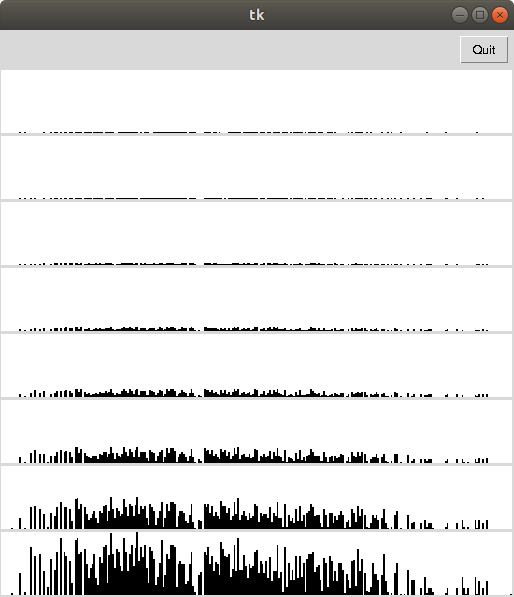

No - this isn't what we want...

* So we need to have iterations spaced by vec_len in order to properly pass the input to each buffer.
* So we need to use a count and take action when the count is a particular value.
* The issue is that our count cannot be infinite but needs to be big enough to trigger the low level only infrequently.

If the times are spaced by a vec_len of 4 you need time steps 0 to 12 in a rolling buffer of length (vec_len^i-vec_len). You then would input time steps vec_len x 0, vec_len x 1, vec_len x 2 up to vec_len x (vec_len-1), i.e. 0, 4, 8, 12 for vec_len = 4. You can then continuously output a value from the second stage, with the stage catching up to the true convolved output at t = 16 (when you have time steps 3, 7, 11, and 16 being the last inputs to the first stage buffer).

Now we look at the second and third stages. The second stage will start producing output after t=12, with getting to the first iteration by t=16. The second stage also needs inputs spaced by vec_len but is fed by vec_len^(i+1) - 4^3 = 64 time steps at the top level. On t=12, t=13 etc the second stage will start outputting continuously.

For example, if there are 8 stages with a vec_len of 4:
* The first stage receives an input every iteration.
* The second stage needs to wait for 16 iterations (4^2). The output from the first stage is buffered over the 16 iterations. 

## Bottom Up - Rolling Mean and Error

In [27]:
class MeanErrorGUI:
    
    def __init__(self, sensor, num_of_buffers=4, group_size=2):
        # Setup gui
        self.window = tk.Tk()
        
        # Setup FPS and Quit Button on First Row
        button_frame = tk.Frame(self.window)
        button_frame.pack(expand=True, fill=tk.BOTH)
        # quit button
        self.quit_button = tk.Button(button_frame, text='Quit', command=lambda: self.quit_())
        self.quit_button.pack(side=tk.RIGHT, padx=5, pady=5)
        
        # Create a list of panels for the GUI
        self.panels = list()
        self.canvas_content = list()
        for i in range(num_of_buffers):
            # Create a canvas for each panel
            canvas = tk.Canvas(self.window, width=512, height=64)
            canvas.pack(expand=True, fill=tk.BOTH)
            self.panels.append(canvas)
            self.canvas_content.append(None)
                         
        # Setup sensor
        self.add_sensor(sensor)
        _, data = self.sensor.read()
        
        # Define rolling mean and error
        self.rolling_sum = np.zeros(shape=(data.shape), dtype=np.uint16)
        self.error = np.zeros(shape=(data.shape))
        self.count = 0
        self.error_count = 0
        
    def add_sensor(self, sensor):
        """Add a sensor to the GUI for display."""
        self.sensor = sensor
        # Start sensor if not already started
        if not self.sensor.started:
            self.sensor.start()
    
    def update(self):
        # Get audio frame
        _, data = self.sensor.read()
        # PBT
        rand_ints = np.random.randint(255, size=(data.shape))
        binary_values = np.where(data > rand_ints, 1, 0)
        # Add to rolling sum
        self.rolling_sum = self.rolling_sum + binary_values
        # Increment count
        self.count += 1
        # Check if count is at 256 and if so reduce by half
        if self.count >= 2**16-1:
            self.count = self.count // 2
            self.rolling_sum = self.rolling_sum // 2
        # Determine the probability
        mean_prob = self.rolling_sum / self.count
        # Determine a re-generated sample based on the probability
        rands = np.random.uniform(size=data.shape[0])
        # PBT based on mean
        sample = np.where(mean_prob > rands, 1, 0)
        error = binary_values - sample
        self.error = self.error + error
        self.error_count += 1
        # normalise error if greater than 255
        if self.error_count >= 128:
            self.error_count = self.error_count // 2
            self.error = self.error // 2
        error_prob = self.error / self.error_count
        display_data = [binary_values*255, error*255, mean_prob*255, error_prob*512]        
        # Display the mean values of each buffer
        for i, array in enumerate(display_data):
            # Convert to image of histogram
            positive_chart_image = convert_to_chart(array)
            negative_chart_image = convert_to_chart(-1*array, flip=False)
            chart_image = np.concatenate([positive_chart_image, negative_chart_image], axis=0)
            # display(chart_image, self.original_fft)
            pil_image = Image.fromarray(chart_image)
            pil_image = pil_image.resize((512, 64))
            photo_image = ImageTk.PhotoImage(image=pil_image)
            if self.canvas_content[i] is None:
                # print("Creating chart")
                self.canvas_content[i] = self.panels[i].create_image(0, 0, image=photo_image, anchor=tk.NW)
            else:
                # print("Configuring chart")
                self.panels[i].itemconfig(self.canvas_content[i], image=photo_image)
                self.panels[i].image = photo_image
                
        self.window.after(30, self.update)
    
    def run(self):
        self.update()
        self.window.mainloop()
        
    def quit_(self):
        self.sensor.stop()
        self.window.destroy()

In [28]:
mean_err = MeanErrorGUI(fftsource, group_size=2)
mean_err.run()

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


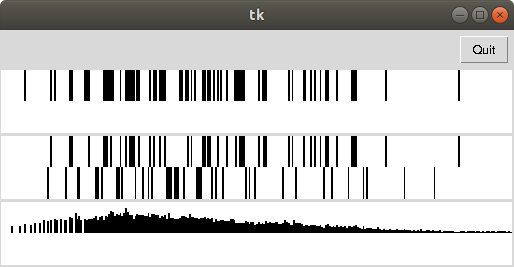

This does appear to work a little - it more evenly distributes the activations over the whole space. And speech does appear in the "error" as a difference from the mean.

The mean at the bottom is also stable. But does change slightly ith conditions.

Also remember that the random errors will cancel each other out over time.

We need the different time scales to capture speech, which involves changes on a relatively short time scale. So sound processing will mainly be applied at the shorter time scales rather than the longer time scales, as this is where the most change occurs.

The "echo" is interesting - this suggests a copy-response listening pattern.

# Spatial Decomposition

We know that we can compute the stage outputs for a stack with an eigenvector of ```[1, 1]``` or use pyrdown to get the difference between different resolutions. We can then compute rolling sums for each of these.

In [29]:
self = mean_err
mean_prob = self.rolling_sum / self.count

In [30]:
mean_prob, self.count

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.20120482, 0.        , 0.        , 0.        ,
        0.20240964, 0.        , 0.        , 0.26506024, 0.        ,
        0.        , 0.23975904, 0.        , 0.34216867, 0.        ,
        0.        , 0.29036145, 0.        , 0.42289157, 0.        ,
        0.42650602, 0.        , 0.48554217, 0.        , 0.39638554,
        0.41325301, 0.        , 0.33493976, 0.        , 0.4       ,
        0.41807229, 0.        , 0.4626506 , 0.38915663, 0.        ,
        0.5373494 , 0.49759036, 0.44939759, 0.42891566, 0.        ,
        0.52771084, 0.48072289, 0.51325301, 0.46385542, 0.4686747 ,
        0.44096386, 0.48674699, 0.39156627, 0.50240964, 0.52771084,
        0.47349398, 0.54457831, 0.51807229, 0.51686747, 0.5253012 ,
        0.44216867, 0.4746988 , 0.49036145, 0.47590361, 0.4939759 ,
        0.47228916, 0.55060241, 0.82650602, 0.57228916, 0.49277108,
        0.46024096, 0.46626506, 0.42168675, 0.45

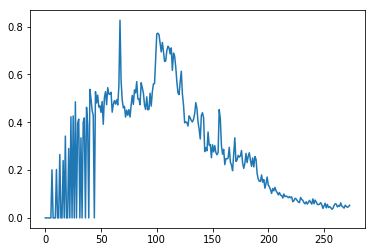

In [31]:
plt.plot(mean_prob)

Again, a little too precise - we really should be storing these as 8-bit values - times by 255 to get ints and then divide by (self.count\*255).

In [32]:
(mean_prob*255).astype(np.uint8)

array([  0,   0,   0,   0,   0,   0,  51,   0,   0,   0,  51,   0,   0,
        67,   0,   0,  61,   0,  87,   0,   0,  74,   0, 107,   0, 108,
         0, 123,   0, 101, 105,   0,  85,   0, 102, 106,   0, 117,  99,
         0, 137, 126, 114, 109,   0, 134, 122, 130, 118, 119, 112, 124,
        99, 128, 134, 120, 138, 132, 131, 133, 112, 121, 125, 121, 125,
       120, 140, 210, 145, 125, 117, 118, 107, 114, 109, 115, 107, 120,
       130, 121, 136, 133, 145, 126, 126, 120, 144, 138, 133, 120, 115,
       129, 115, 115, 133, 119, 134, 142, 143, 169, 196, 196, 195, 185,
       176, 187, 177, 166, 167, 178, 183, 181, 174, 181, 157, 175, 172,
       160, 145, 133, 131, 145, 156, 131, 120, 101, 102, 101,  98, 108,
       106, 103, 102, 105, 111, 122, 116, 102,  94,  84, 109, 112, 106,
        70,  74,  71,  91,  77,  78,  64,  78,  70,  77,  69,  67,  69,
       115, 105,  76,  67,  73,  56,  63,  62,  63,  75,  59,  56,  50,
        68,  85,  60,  61,  66,  64,  66,  71,  58,  52,  58,  6

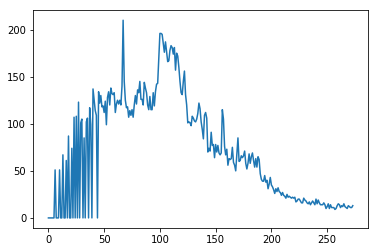

In [33]:
plt.plot((mean_prob*255).astype(np.uint8))

In [34]:
mean = (mean_prob*255).astype(np.uint8)
reduced = cv2.pyrDown(mean)

In [35]:
mean.shape, reduced.shape

((274,), (137, 1))

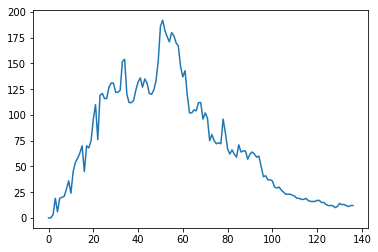

In [36]:
plt.plot(reduced)

In [37]:
reduced.T

array([[  0,   0,   3,  19,   6,  19,  20,  21,  28,  36,  24,  45,  54,
         58,  63,  70,  45,  70,  68,  75,  96, 110,  76, 119, 121, 116,
        116, 127, 131, 131, 122, 122, 124, 152, 154, 120, 112, 112, 114,
        124, 132, 136, 127, 135, 131, 121, 120, 124, 133, 152, 186, 192,
        182, 176, 171, 180, 177, 170, 167, 147, 137, 143, 119, 102, 102,
        105, 104, 112, 112,  96, 102,  97,  75,  81,  75,  72,  73,  72,
         96,  83,  67,  62,  66,  62,  59,  71,  64,  65,  65,  57,  62,
         64,  62,  59,  60,  50,  40,  41,  37,  37,  36,  30,  29,  30,
         27,  25,  23,  23,  23,  22,  21,  19,  19,  18,  18,  19,  17,
         16,  16,  16,  17,  17,  15,  15,  13,  12,  12,  12,  10,  11,
         14,  13,  13,  12,  11,  12,  12]], dtype=uint8)

Cool - so pyrdown works fine on 1D input. But what about on PBT output?

In [38]:
rand_ints = np.random.randint(255, size=(data.shape))
binary_values = np.where(mean > rand_ints, 1, 0)
print(binary_values)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1
 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0
 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1
 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [39]:
reduced_bin = cv2.pyrDown(binary_values.astype(np.uint8)); print(reduced_bin.T)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1
  0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0
  1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


Cool - it does work on binary values. Does pyrUp also work?

In [40]:
reconstruct = cv2.pyrUp(reduced_bin); print(reconstruct.T)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
  0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1
  1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1
  1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
  0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1
  1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1
  1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [41]:
def getsize(img):
    h, w = img.shape[:2]
    return w, h

In [42]:
getsize(reduced_bin)

(1, 137)

In [43]:
reconstruct = cv2.pyrUp(reduced_bin, dstsize=(1, reduced_bin.shape[0]*2)); print(reconstruct.T)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
  0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1
  1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1
  1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [44]:
binary_values.shape, reconstruct.shape

((274,), (274, 1))

In [45]:
error = binary_values.reshape(-1, 1) - reconstruct; print(error.T)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0 -1  0 -1  1  0  0  0  0  0
  -1  0  0  0  0 -1  0  0  0  0  1  0  0  0 -1  0  0 -1  0  0 -1  0  0 -1
   0  1  0  0  0 -1  0  0  0 -1  0  0  1  0  0  0  0  0 -1  0  0 -1  0  0
  -1  0  0 -1  0  0  0  0 -1  0  0 -1  0  0 -1  0  0  0  0 -1  0  0  0 -1
   0  0  0  0  1  0  0  0  0  0 -1  0 -1  0  0  0  0  0 -1  0  0  0  1 -1
   0  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
   0  0  0  0  1 -1  0 -1  1  0  0  0 -1  0  0 -1  1  0  0  0  1  0  0  0
   0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0
   0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0]]


So, a method:
* PBT input.
* Generate a binary pyramid - down and up.
* Compute differences - this will be a list of arrays. Clip at 1, -1.
* Sum differences + lowest point to determine mean. This will be a single-time but different spatial mean.

What to visualise?
* Original signal.
* PBT of original signal.
* Lowest mean expanded across all samples.
* For each difference layer - sum of mean's of layer below spread out over original space.

We can show the diffs on one side and the means on the other.

Variables needed:
* 

In [46]:
np.log2(137).astype(np.uint8)

7

In [47]:
for i in range(np.log2(137).astype(np.uint8),-1,-1):
    print(2**i)

128
64
32
16
8
4
2
1


In [48]:
cols = 8
new_cols = cols//2 if cols != 1 else 1; print(new_cols)

4


In [49]:
binary_values[:256].shape

(256,)

In [50]:
diffs = get_differences(binary_values[:256].reshape(-1, 1).astype(np.uint8), clip=True)

In [51]:
len(diffs)

9

In [52]:
for i, diff in enumerate(diffs):
    print(f"Level {i} - shape {diff.shape} - data:\n{diff.T}\n")

Level 0 - shape (256, 1) - data:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0 -1  0 -1  1  0  0  0  0  0
  -1  0  0  0  0 -1  0  0  0  0  1  0  0  0 -1  0  0 -1  0  0 -1  0  0 -1
   0  1  0  0  0 -1  0  0  0 -1  0  0  1  0  0  0  0  0 -1  0  0 -1  0  0
  -1  0  0 -1  0  0  0  0 -1  0  0 -1  0  0 -1  0  0  0  0 -1  0  0  0 -1
   0  0  0  0  1  0  0  0  0  0 -1  0 -1  0  0  0  0  0 -1  0  0  0  1 -1
   0  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
   0  0  0  0  1 -1  0 -1  1  0  0  0 -1  0  0 -1  1  0  0  0  1  0  0  0
   0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0
   0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  1]]

Level 1 - shape (128, 1) - data:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1  0  0
   0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0

What about the cancellation of +ve and -ve errors in the means of the errors?

I've got a feeling this is okay - as the differences just show up at the respective scales.

Also would it actually be faster to use a 2D array with repeated values? Rather than a for loop with decreasing numbers of values?

In [53]:
np.repeat(diffs[-2], 1)

array([0, 0], dtype=int8)

In [54]:
2**0

1

In [55]:
diffs_as_2D = np.zeros(shape=(diffs[0].shape[0], len(diffs)), dtype=np.int16)
for i, diff in enumerate(diffs):
    diffs_as_2D[:, i] = np.repeat(diff, 2**i)

In [56]:
rolling_2D = np.zeros(shape=(diffs[0].shape[0], len(diffs)), dtype=np.int16)

In [57]:
%%timeit
rolling_2D = np.zeros(shape=(diffs[0].shape[0], len(diffs)), dtype=np.int16)
rolling_2D = rolling_2D + diffs_as_2D

4.34 µs ± 81 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [58]:
%%timeit
rolling_2D = np.zeros(shape=(diffs[0].shape[0], len(diffs)), dtype=np.int16)

1.65 µs ± 38.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [59]:
layer_sums = [
    np.zeros(shape=(d.shape[0],), dtype=np.int16)
    for d in diffs                   
]

In [60]:
%%timeit
layer_sums = [
    np.zeros(shape=(d.shape[0],), dtype=np.int16)
    for d in diffs                   
]

8.23 µs ± 57.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [61]:
%%timeit
for d, layer_sum in zip(diffs, layer_sums):
    layer_sum = layer_sum + d

107 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


So we get a 20x speed up with bigger arrays at the lower levels through the parallelism!

In [62]:
%%timeit
np.repeat(diffs[-2], 8)

1.79 µs ± 50.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


And repeat is very fast as well - so even if we run this 9 times we still get a 80 us speed up per loop - and need to do less conversion to visualise.

What is the speed difference between cv2.pyrDown and convolve for 1D?

In [63]:
%%timeit
cv2.pyrDown(binary_values[:256].reshape(-1, 1).astype(np.uint8))

9.26 µs ± 203 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [64]:
%%timeit
np.convolve(binary_values[:256].reshape(256, ).astype(np.uint8), np.asarray([1, 4, 6, 4, 1])/16)

17.9 µs ± 286 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


So faster to use cv2 then repeat than to bother with convolving in numpy.

In [65]:
%%timeit
diffs = get_differences(binary_values[:256].reshape(-1, 1).astype(np.uint8), clip=True)

145 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<IPython.core.display.Javascript object>


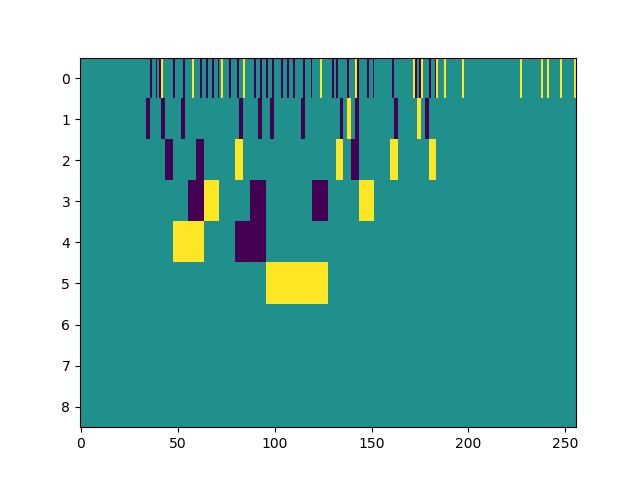

In [66]:
%matplotlib notebook
diffs = get_differences_2D(binary_values[:256].reshape(-1, 1).astype(np.uint8), clip=True)

plt.imshow(diffs.T, aspect="auto")

In [67]:
%%timeit
diffs = get_differences_2D(binary_values[:256].reshape(-1, 1).astype(np.uint8), clip=True)

191 µs ± 2.48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [68]:
mean_probs = diffs/1

In [69]:
class AbstractGUI:
    
    def __init__(self, sensor):
        # Setup gui
        self.window = tk.Tk()
        
        # Setup FPS and Quit Button on First Row
        button_frame = tk.Frame(self.window)
        button_frame.pack(expand=True, fill=tk.BOTH)
        # quit button
        self.quit_button = tk.Button(button_frame, text='Quit', command=self.quit_)
        self.quit_button.pack(side=tk.RIGHT, padx=5, pady=5)
        
        # Setup sensor
        self.add_sensor(sensor)
        
        # Create a list of panels for the GUI
        self.panels = list()
        self.canvas_content = list()
        
    def add_sensor(self, sensor):
        """Add a sensor to the GUI for display."""
        self.sensor = sensor
        # Start sensor if not already started
        if not self.sensor.started:
            self.sensor.start()
    
    def update(self):
        pass
        
    
    def run(self):
        self.update()
        self.window.mainloop()
        
    def quit_(self):
        self.sensor.stop()
        self.window.destroy()

In [70]:
class SignalFrame:
    """Object to display signals."""
    def __init__(self, parent, subpanels=4, width=256, height=64, packing=tk.TOP):
        """Initialise.
        
        Args:
            parent - parent Tk object.
            subpanels - number of subpanels.
            width - subpanel width in pixels.
            height - subpanel height in pixels.
        """
        self.frame = tk.Frame(parent)
        self.frame.pack(side=tk.LEFT, expand=True, fill=tk.BOTH)
        self.panels = list()
        self.canvas_content = list()
        self.width = width
        self.height = height
        for _ in range(subpanels):
            # Create a canvas for each panel
            canvas = tk.Canvas(self.frame, width=width, height=height)
            canvas.pack(side=packing)
            self.panels.append(canvas)
            self.canvas_content.append(None)
    
    def update(self, arrays, signed=True):
        """Update frame with image of array.
        
        Args:
            arrays - a list of numpy arrays.
        """
        # Display the mean values of each buffer
        for i, array in enumerate(arrays):
            chart_image = convert_to_chart(array)
            if signed:
                negative_chart_image = convert_to_chart(-1*array, flip=False)
                chart_image = np.concatenate([chart_image, negative_chart_image], axis=0)
            pil_image = Image.fromarray(chart_image)
            pil_image = pil_image.resize((self.width, self.height))
            photo_image = ImageTk.PhotoImage(image=pil_image)
            if self.canvas_content[i] is None:
                # print("Creating chart")
                self.canvas_content[i] = self.panels[i].create_image(0, 0, image=photo_image, anchor=tk.NW)
            else:
                # print("Configuring chart")
                self.panels[i].itemconfig(self.canvas_content[i], image=photo_image)
                self.panels[i].image = photo_image  

Let's just start with:
1. Stack 1:
    * The input signal (non_binary)
    * The input signal (binary)
2. Stack 2:
    * Diffs at each level
3. Stack 3:
    * Means at each level

In [71]:
np.log2(256).astype(np.uint8)

8

In [72]:
class BinaryLayerMeanGUI(AbstractGUI):
    
    def __init__(self, sensor, run=True):
        super().__init__(sensor)
        # Read data to initialise sizes
        _, data = self.sensor.read()
        # Determine data length as nearest power of 2 - will crop end of signal - ok with sound
        self.data_length_pow = np.log2(data.shape[0]).astype(np.uint8)
        # Create a list of panels for the GUI
        self.input_frame = SignalFrame(self.window, subpanels=2, width=512, height=256)
        self.diffs_frame = SignalFrame(self.window, subpanels=self.data_length_pow+1, width=256, height=64)
        self.means_frame = SignalFrame(self.window, subpanels=self.data_length_pow+1, width=256, height=64)
        self.summed_frame = SignalFrame(self.window, subpanels=self.data_length_pow+1, width=256, height=64)
            
        # Define rolling sums for each layer (including lowest)
        self.layer_sums = np.zeros(
            shape=(2**self.data_length_pow, self.data_length_pow+1), 
            dtype=np.int16
        )
            
        self.count = 0
        
        if run:
            self.run()
        
    
    def update(self):
        # Get audio frame
        _, data = self.sensor.read()
        clipped_data = data[:256]
        # PBT
        rand_ints = np.random.randint(255, size=(clipped_data.shape))
        binary_values = np.where(clipped_data > rand_ints, 1, 0).astype(np.uint8)
        # Update first set of panels
        self.input_frame.update([clipped_data, binary_values*255], signed=False)
        # Get differences via image pyramid
        diffs = get_differences_2D(binary_values[:256].reshape(-1, 1), clip=True)
        # Update diffs panels
        self.diffs_frame.update(diffs.T*255, signed=True)
        # Add to rolling sum
        self.layer_sums = self.layer_sums + diffs
        # Increment count
        self.count += 1
        # Check if count is at 256 and if so reduce by half
        if self.count >= 2**16-1:
            self.count = self.count // 2
            self.layer_sums = self.layer_sums // 2
            
        # Determine the probability
        mean_probs = self.layer_sums / self.count
        self.means_frame.update(mean_probs.T*255)
        
        # We need an extra step in here where we generate according to the probabilities
        
        # Then we sum the probabilities
        
        # Determine cumulative sums (flip to sum from bottom)
        cumsums = np.cumsum(np.flip(self.layer_sums, axis=1), axis=1) / self.count
        # Flip back to match means order
        flipped_cumsums = np.flip(cumsums, axis=1)
        # Display
        self.summed_frame.update(flipped_cumsums.T*255)
        
        self.window.after(30, self.update)
    

Aside - numpy has a diff function:
https://numpy.org/doc/stable/reference/generated/numpy.diff.html#numpy.diff

In [73]:
gui_1 = BinaryLayerMeanGUI(fftsource)

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


In [74]:
gui_1.layer_sums.shape

(256, 9)

In [75]:
gui_1.layer_sums[:, -1]

array([639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 63

In [76]:
flipped = np.flip(gui_1.layer_sums, axis=1); flipped[:, 0]

array([639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 639, 63

In [77]:
cumsums = np.cumsum(flipped, axis=1)

In [78]:
cumsums[:, -1]

array([    0,     0,     0,     0,     0,     0,   344,     0,     0,
           0,   307,     0,     0,   409,     0,     0,   329,   -21,
         436,   -21,   -53,   175,  -181,   191,   -48,   294,  -143,
         281,   -89,   265,   345,  -181,  -136,  -800,  -216,  -379,
        -809,  -381,  -536, -1287,  -481,  -875,  -747,  -869, -1531,
       -1335, -1321, -1489,  -680,  -827,  -943, -1074, -1014, -1201,
       -1148, -1392,  -983, -1285, -1173, -1361, -1247, -1478, -1385,
       -1608,   623,   326,   361,   133,   384,    88,   -33,  -359,
         940,   387,   291,    77,   209,    19,     6,  -247,   311,
         124,   161,   -49,   106,  -135,   -32,  -239,   -98,  -278,
        -320,  -540,  -414,  -657,  -651,  -955,   457,   166,   150,
         -33,   368,   149,   157,   144,   574,   347,   368,   274,
         387,   238,   312,   285,   689,   628,   572,   402,   599,
         499,   348,    96,   386,   189,   224,   -36,   263,   -68,
         -13,  -217,

In [79]:
flipped[:, 1]

array([  -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,
         -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,
         -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,
         -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,
         -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,
         -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,
         -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,
         -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,
         -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,
         -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,
         -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,   -3,
         -3,   -3,   -3,   -3,   -3,   -3,   -3, -328, -328, -328, -328,
       -328, -328, -328, -328, -328, -328, -328, -328, -328, -328, -328,
       -328, -328, -328, -328, -328, -328, -328, -3

In [80]:
cumsums = np.cumsum(np.flip(self.layer_sums, axis=1), axis=0) / self.count


# Flip back to match means order
flipped_cumsums = np.flip(cumsums, axis=0)
# Display
self.summed_frame.update(flipped_cumsums.T*255)

AttributeError: 'MeanErrorGUI' object has no attribute 'layer_sums'

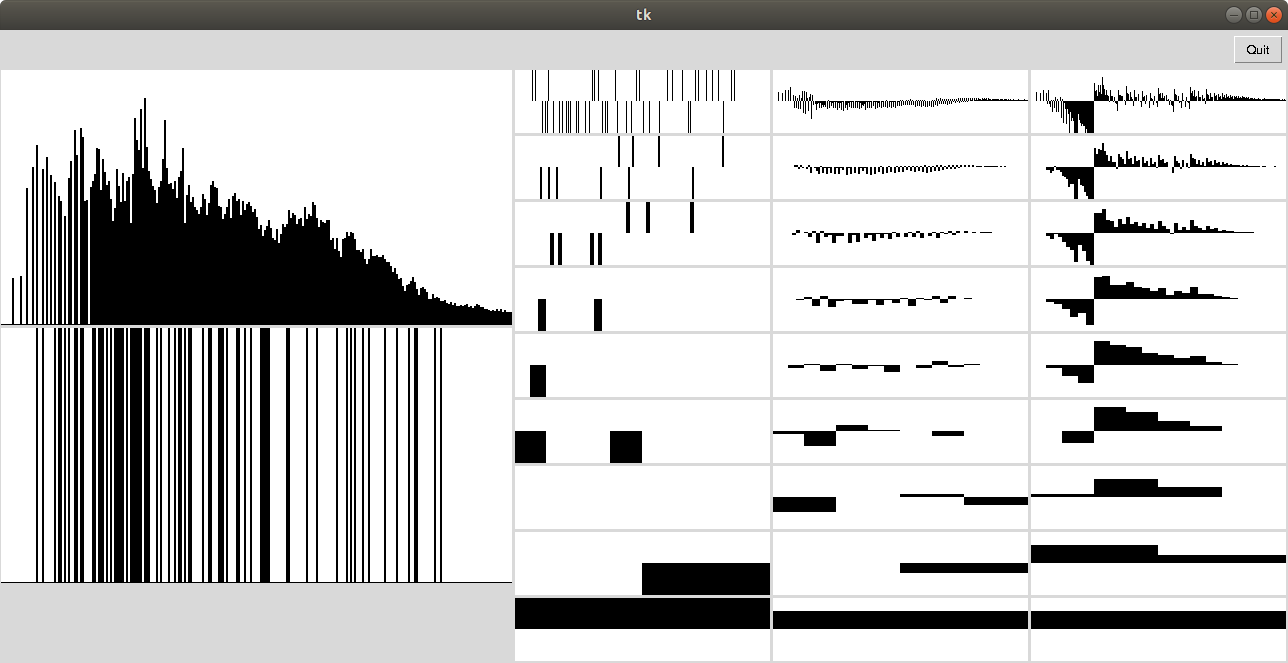

So in the methods above we are:
* Getting 1D input.
* PBT to get binary input.
* Building a difference pyramid by comparing a given level with an upsampled version of that level.
* Summing the differences over time and dividing by count to generate probabilities at each stage.
* (Erroneously) generating a cumulative sum of the probabilities.

The means at each level should be zero? The "checkerboard" pattern is due to clipping within the up and down sampling (this could be avoided if we included 2>-2)?

If we had shorter term means, would would get greater differences.

Just summing the values to reconstruct doesn't work - what we need to do is sum the values generated with the probabilities.

So what we would need to do is:
* Sum the generative results at each level.
* Where we generate using the probabilities not the actual means.
* Normalise somehow to keep without input range (e.g. 0 to 255).

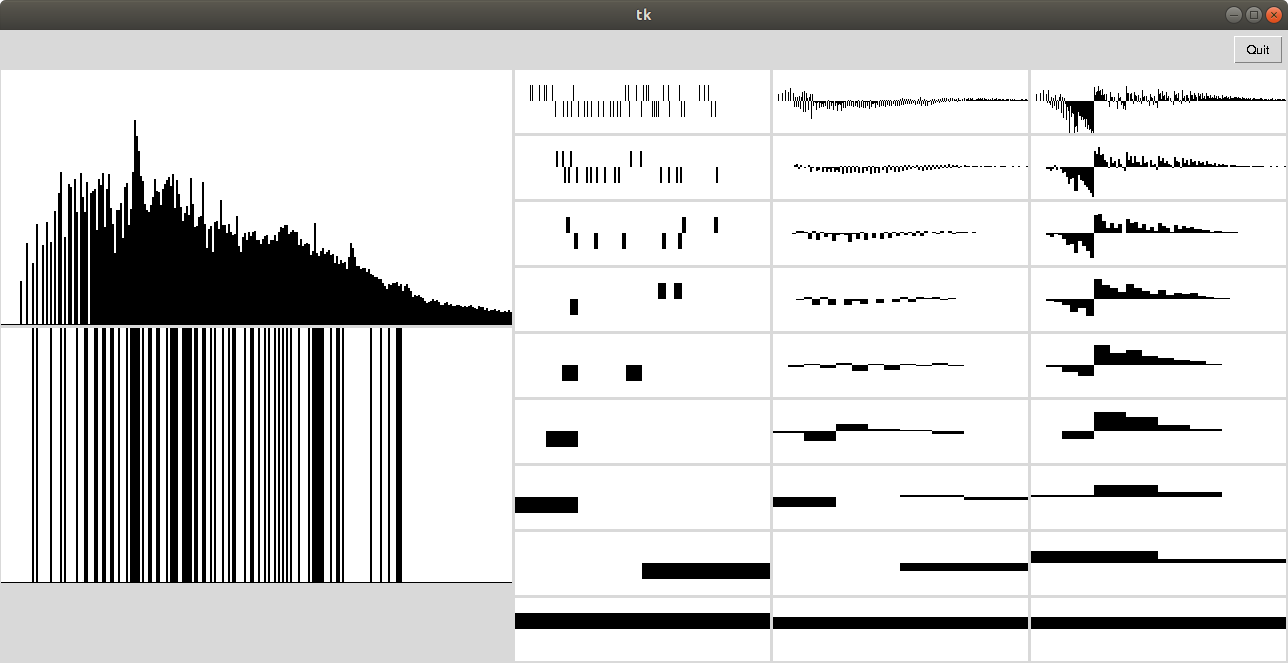

Even when we don't clip, the 2 or -2 differences don't really appear. So it looks as though we can clip...BUT clipping introduces distortions when looking at some of the calculations - better to PBT with scaled values?

This is only possible as we have binary values entering in at the top.

Time averages require considerations that are not required for space averages. This is because our values are being revealed sequentially. With a 1D array we have all the values in the array, so can compute a lowest layer that is derived from all the higher layers. However, with time we do not have all the time values for the lowest layer - half of the values exist in the future and we have no access to this. Hence, we are limited to computing time averages based only on the past - half the input of space at any one time.

What would be good is to build a time-stack > generate sums over time for 8 different 4x periods. Then view these. This will check we don't have 0-means for short term groups.

For this we need a mean_buffer style object. This will have a 2D layer sum array. But will reset for different time periods. So we generate the differences and pass to each stage.

On recurring problem we have is transitions when we get to long time periods:
* For short time periods, we can use a running estimate where we add the new value and remove the old value. However, this requires maintaining a buffer of the length of the time period - okay for 4 to 256 but problematic beyone 256 or 1024.
* Can we approximate by adding and removing the average over a time block? (E.g. you could have a rolling average when you added the newest 1/4 and removed the oldest 1/4). ***But we have those estimates from the time layer above.***
* So we have a rolling average of size time_period. We then take a rolling average of that rolling average etc etc. This way we only need buffers of length time_period at each stage. ***But what amount Zeno's paradox - we need to wait until the previous stage has finished before we can compute the stage below...*** We can use a rolling sum while waiting?

So we'd have, with time period = 4:
* Set all stages computing a rolling sum.
* Also have, in parallel, a buffer.
* So each stage would receive the diffs at each time stamp *and* an output from the stage above?
* This is a combination of our approaches?
* How do we implement this in an iterative loop at the lowest level?
    * On the fourth iteration, we'd output a mean_prob from the first stage and add this to the buffer of the stage below.
    * This would be repeated on the 8th, 12th and 16th iterations. On the 16th iteration, the buffer of the stage below will output.
    * You pass both the difference data for the time step and any output from a previous stage. Maybe if the output is None you do nothing but if non-zero you add to the buffer.
    * We don't even need to maintain counts? We just use the fullness of the buffer as the count. Or we just count the number of non-zero buffer inputs and output the rolling buffer sum once the buffer is full.
* But if we have a rolling output, we can produce values every timestep. We can use this for local calculation of the mean_prob but not to update layers below.

* Do we want to be using the covariance? I.e. otherwise positive and negative differences cancel out in the mean? And we then assume these occur symmetrically?
    * These would need to be computed as a list of smaller arrays - otherwise we do a lot of extra maths?
    * We are computing X.X^T - was this just the sign data? Yes - doing sign(dot(X, X^T) - but actually with binary variables this is what X.X^T outputs.
    * We could just concatenate the different stages to generate a longer X - compute X.X^T then only take the diagonals of the parts we want.

---
# Resummarise 

We need to split the above in two:
1) Using correlation to determine the mean.
2) Different length time stages in parallel.

1 just means we have a rolling correlation matrix as opposed to a sum. The diagonals give us our sum.

But still in 2) we're not looking at the differences - just the averages. So we should also be computing the differences between the different time scales?
* The problem with this is that we need a future time estimate to subtract...for example a second layer with t=4 that covers 16 time steps is only available after 16 times steps - what do we do for this?
* Also we are always comparing with a previous time - in space you have access to all the dimensions, in time just the past ones. So we are always subtracting the most recent past estimate for that layer. Or if that is not available the rolling sum estimate for that layer.
* We need to subtract the last available average from a lower level - in space this would be a left-hand side unit as the "current" unit is not available until the data has been received and processed at higher levels.

In [81]:
for i in range(8):
    print(4**i)

1
4
16
64
256
1024
4096
16384


In [82]:
cumsum = 0
for i in range(8):
    cumsum += 2**i
    print(i, 2**i, cumsum)

0 1 1
1 2 3
2 4 7
3 8 15
4 16 31
5 32 63
6 64 127
7 128 255


It's just one less than the next scale above. So for 256 we have 511. Or 261121 values.

In [83]:
class MeanBuffer:
    """This is similar to our sensor and buffer objects."""
    
    def __init__(self, data_len, stages, time_period):
        """Initialise.
        
        Args:
            data_len - integer length of 1D array being processed.
            stages - number of spatial stages being processed.
            time_period - number of time steps for buffering.
        """
        self.time_period = time_period
        # Define a general count for the rolling sum
        self.count = 0
        # Define a count for the buffer entries
        self.buffer_count = 0
        # Define rolling sums for each layer (including lowest)
        self.running_sum = np.zeros(
            shape=(data_len, stages), 
            dtype=np.int16
        )
        # Define in parallel a rolling buffer
        self.buffered_means = np.zeros(
            shape=(data_len, stages, time_period), 
            dtype=np.int16
        )
        # Define a flag that indicates buffer data is available
        self.use_buffer = False
        
    def iterate(self, input_data, buffer_data):
        """Iterate using input_data.
        
        Args:
            input_data - 2D array the same size as running_sum.
                This is the data from each time step.
            buffer_data - 2D array representing an input from a buffer
                above (e.g. shorter time period).
        Returns:
            """
        # Set a flag for returning buffer data
        return_buffer = False
        # Don't return anything until buffer is full
        return_data = None
        # Use rolling sum if no data in buffer 
        if not self.use_buffer:
            self.count += 1
            self.running_sum += input_data
            # Check for overflow on running sum
            if self.count >= 2**16-1:
                self.count = self.count // 2
                self.running_sum = self.running_sum // 2
        # Check if buffer data
        if buffer_data is not None:
            self.buffered_means[..., self.buffer_count] = buffer_data.ravel()
            self.buffer_count += 1
            if (self.buffer_count) % self.time_period == 0:
                # Stop with the rolling sum
                # Reset buffer count
                self.buffer_count = 0
                self.use_buffer = True
                return_buffer = True
        if return_buffer:
            return_data = self.mean_probs
        return return_data
    
    @property
    def mean_probs(self):
        """Return mean probabilities."""
        # If no buffered mean
        if self.use_buffer:
            mean_probs = self.buffered_means / self.time_period
        else:
            mean_probs = self.running_sum / self.count
        return mean_probs
    
    def __repr__(self):
        """Print output."""
        return self.mean_probs

In [84]:
mb = MeanBuffer(16, 4, 4)

In [85]:
rand_input = np.random.randint(-1, high=2, size=(16, 4))
print(rand_input)

[[ 0  0  0 -1]
 [ 0 -1 -1 -1]
 [ 0  0  0  1]
 [ 0 -1  0  0]
 [ 0 -1  0  0]
 [ 1 -1  1  0]
 [-1 -1  1 -1]
 [ 1  1 -1 -1]
 [ 0  1  1 -1]
 [-1 -1  1  1]
 [-1  1  0  0]
 [ 0 -1 -1  0]
 [ 0  0  0  1]
 [ 0  1  1  1]
 [-1 -1  1  0]
 [ 0  0  1 -1]]


In [86]:
for i in range(16):
    rand_input = np.random.randint(-1, high=2, size=(16, 4))
    output = mb.iterate(rand_input, None)
    print(mb.running_sum.T, mb.buffered_means.T, mb.mean_probs.T, output, sep="\n---\n", end="\n\n")

[[-1  1 -1  0  0  1 -1  0  1  0  1 -1  1  0 -1  0]
 [ 0  0 -1 -1  1  1  0  1  0  1  0  0  1  1  0  0]
 [-1 -1  0  0  1 -1  0  0  0  0  0  0 -1  1  1  0]
 [-1 -1 -1  1  1  1  1  1  1  1 -1  0  1  1 -1  0]]
---
[[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]]
---
[[-1.  1. -1.  0.  0.  1. -1.  0.  1.  0.  1. -1.  1.  0. -1.  0.]
 [ 0.  0. -1. -1.  1.  1.  0.  1.  0.  1.  0.  0.  1.  1.  0.  0.]
 [-1. -1.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0. -1.  1.  1.  0.]
 [

In [87]:
mb.count

16

Remember the mean probabilities are different from the downsampled signal.

We have to be careful whether we are taking probabilities or signal samples.

We compute our probabilities based on the downsampled spatial signals.

If we were applying the same approach in time as well as space:
* We buffer time_period samples then pyrDown then pyrUp the result.
* So we would pyrDown the buffer then pyrUp that result then subtract the pyrUp from the buffer?

In [88]:
ones = np.ones(shape=(4, 1), dtype=np.uint8)

In [100]:
rand = np.random.randint(2, size=(8, 1), dtype=np.uint8)
pyrdown = cv2.pyrDown(rand)
pyrup = cv2.pyrUp(pyrdown, dstsize=(1, rand.shape[0]))
diff = (rand - pyrup).astype(np.int8)
print(rand.T, pyrdown.T, pyrup.T, diff.T)

[[0 0 1 1 0 0 0 0]] [[0 1 0 0]] [[0 1 1 1 0 0 0 0]] [[ 0 -1  0  0  0  0  0  0]]


```[[0 0 1 1 0 1 1 0]] [[0 1 1 1]] [[0 1 1 1 1 1 1 1]] [[ 0 -1  0  0 -1  0  0 -1]]```

This is why you have that checkboard pattern on the means - the cv2 pyrDown smears the values so you are more likely to get -1s when looking at the difference.

It creates "sparse" differences where "sparse" = separated by zeros - you can more easily process independently.